# Import Library: 분석에 사용할 모듈 설치
**1. Import Library**

In [37]:
!python -m pip install --user --upgrade pip
!pip install xgboost
!pip install lightgbm

Requirement already up-to-date: pip in c:\users\kk\appdata\roaming\python\python36\site-packages (19.0.3)


In [38]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [39]:
### Feature engineering of default
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    # bring back
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('H', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe
# raw_rd = non_feature_engineering(raw_all)


### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe
# raw_fe = feature_engineering(raw_all)


### Data split of cross sectional
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_fe, Y_colname, X_colname, 0.2)


### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)


### Error analysis
def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.graphics.tsa.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.graphics.tsa.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])      

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                             index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
    for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
        Stationarity['Critical Value(%s)'%key] = value
        Stationarity['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
        Stationarity = pd.DataFrame(Stationarity, columns=['Stationarity'])

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    Score = Score.loc[['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                       'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria'],:]
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

# Base분석 결과확인

## Code Summary (Raw Data)

Train_size: (13128, 12) Test_size: (4416, 12)
X_train: (13128, 8) Y_train: (13128, 1)
X_test: (4416, 8) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     2889.
Date:                Wed, 13 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:40:09   Log-Likelihood:                -83421.
No. Observations:               13128   AIC:                         1.669e+05
Df Residuals:                   13120   BIC:                         1.669e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         3.3659      1.286      2.618      0.009       0.846       5.886
holiday       -6.2896      7.466     -0.842      0.400     -20.924       8.345
workingday    10.3553      2.641      3.921      0.000       5.178      15.533
weather        7.1906      2.093      3.436      0.001       3.089      11.292
temp          -7.8544      1.222     -6.429      0.000     -10.249      -5.460
atemp         16.0695      1.095     14.676      0.000      13.923      18.216
humidity      -1.7353      0.063    -27.356      0.000      -1.860      -1.611
windspeed      2.2749      0.136     16.745      0.000       2.009       2.541
==============================================================================
Omnibus:                     2168.771   Durbin-Watson:                   0.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3942.747
Skew:                           1.050   Prob(JB):                         0.00
Kurtosis:                       4.672   Cond. No.                         450.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,MAE,MSE,MAPE
Train,103.09,"19,360.42",458.48
Test,150.03,"43,410.27",316.61


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.25,0.94,"8,204.84","12,494.43","13,138.03","48,485.56",1.76
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,40.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,087.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"143,252.82",nan,nan,nan,nan,nan,NaN


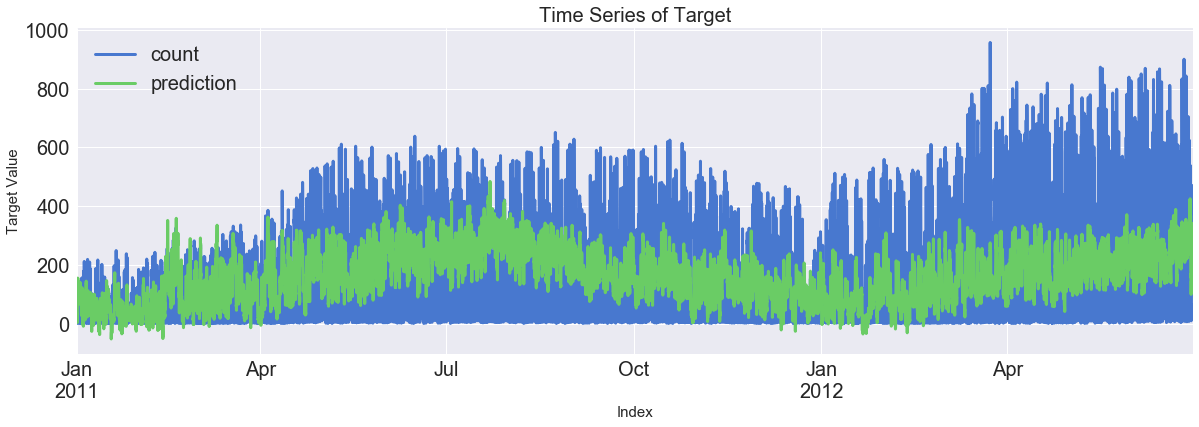

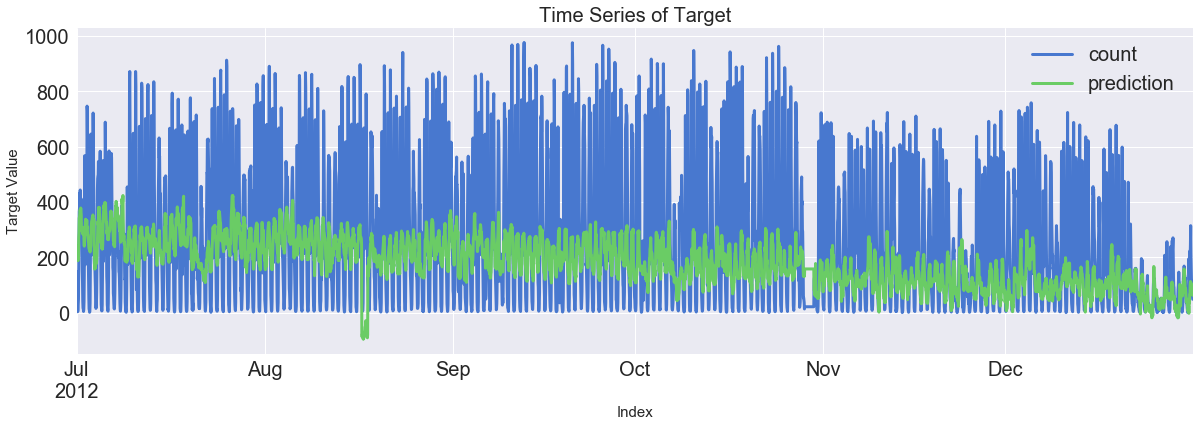

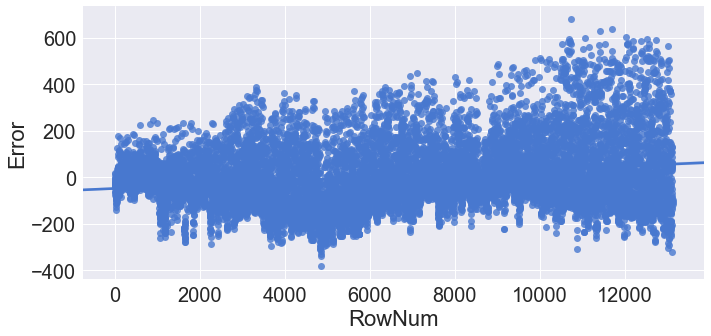

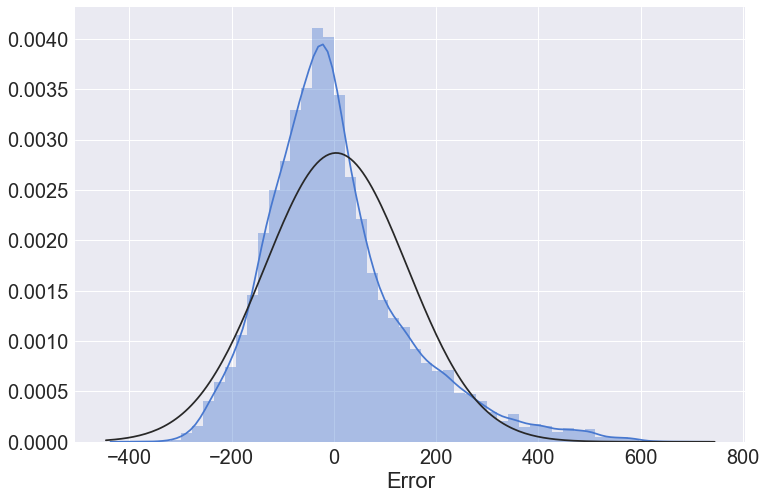

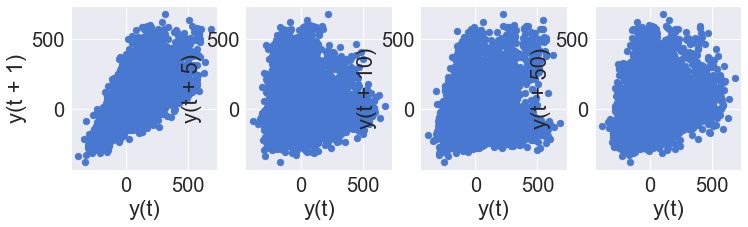

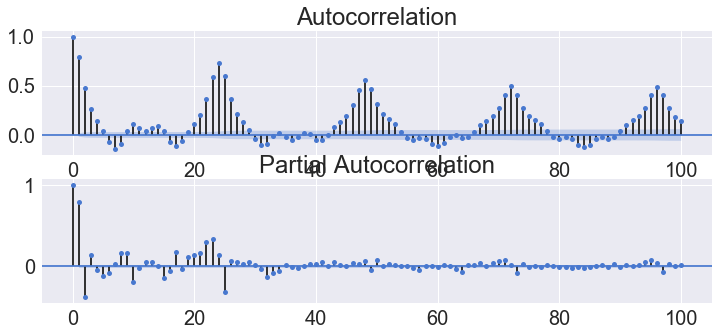

In [40]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = '../Data/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_rd = non_feature_engineering(raw_all)

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_rd.columns if x not in Y_colname+X_remove]
X_train_rd, X_test_rd, Y_train_rd, Y_test_rd = datasplit_ts(raw_rd, Y_colname, X_colname, '2012-07-01')

# Applying Base Model
fit_reg1_rd = sm.OLS(Y_train_rd, X_train_rd).fit()
display(fit_reg1_rd.summary())
pred_tr_reg1_rd = fit_reg1_rd.predict(X_train_rd).values
pred_te_reg1_rd = fit_reg1_rd.predict(X_test_rd).values

# Evaluation
Score_reg1_rd, Resid_tr_reg1_rd, Resid_te_reg1_rd = evaluation_trte(Y_train_rd, pred_tr_reg1_rd, 
                                                                Y_test_rd, pred_te_reg1_rd, graph_on=True)
display(Score_reg1_rd)

# Error Analysis
error_analysis(Resid_tr_reg1_rd, ['Error'], X_train_rd, graph_on=True)

## Code Summary (Feature Engineering Data)

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.362e+08
Date:                Wed, 13 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:40:16   Log-Likelihood:                 1906.2
No. Observations:               13128   AIC:                            -3764.
Df Residuals:                   13104   BIC:                            -3585.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0005      0.004     -0.129      0.897      -0.009       0.008
holiday            0.0083      0.014      0.612      0.540      -0.018       0.035
workingday         0.0079      0.007      1.184      0.236      -0.005       0.021
weather            0.0042      0.003      1.232      0.218      -0.003       0.011
temp               0.0022      0.002      1.075      0.282      -0.002       0.006
atemp             -0.0025      0.002     -1.347      0.178      -0.006       0.001
humidity          -0.0001      0.000     -0.845      0.398      -0.000       0.000
windspeed          0.0003      0.000      1.062      0.288      -0.000       0.001
count_trend     9.161e-05   8.57e-05      1.069      0.285   -7.64e-05       0.000
count_seasonal  1.984e-05   2.56e-05      0.775      0.438   -3.03e-05       7e-05
count_Day       4.177e-05   8.36e-05      0.500      0.617      -0.000       0.000
count_Week     -4.345e-05   9.61e-05     -0.452      0.651      -0.000       0.000
count_diff         1.0000    2.9e-05   3.45e+04      0.000       1.000       1.000
Year           -1.547e-05   7.97e-06     -1.939      0.052   -3.11e-05    1.66e-07
Quater_ver2        0.0004      0.002      0.180      0.857      -0.004       0.005
Month              0.0026      0.002      1.051      0.293      -0.002       0.007
Day                0.0004      0.000      1.728      0.084   -4.91e-05       0.001
Hour               0.0006      0.000      1.538      0.124      -0.000       0.001
DayofWeek          0.0003      0.002      0.224      0.823      -0.003       0.003
count_lag1         1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
count_lag2     -1.926e-05   2.59e-05     -0.744      0.457      -7e-05    3.15e-05
Quater_Dummy_2    -0.0010      0.009     -0.115      0.909      -0.019       0.017
Quater_Dummy_3    -0.0037      0.017     -0.220      0.826      -0.037       0.030
Quater_Dummy_4    -0.0132      0.026     -0.512      0.609      -0.064       0.037
==============================================================================
Omnibus:                    54426.083   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93552024983.782
Skew:                        -114.255   Prob(JB):                         0.00
Kurtosis:                   13078.751   Cond. No.                     3.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,MAE,MSE,MAPE
Train,0.01,0.04,0.06
Test,0.01,0.00,0.03


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.98,0.01,0.00,0.01,0.03,0.10,0.00
p-value,0.00,0.00,0.98,1.00,1.00,1.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-106,845.57",nan,nan,nan,nan,nan,NaN


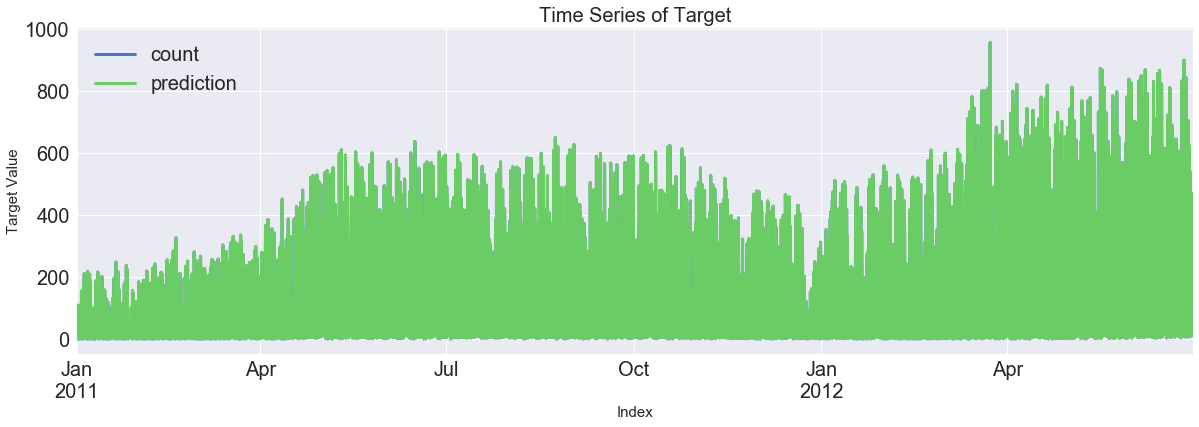

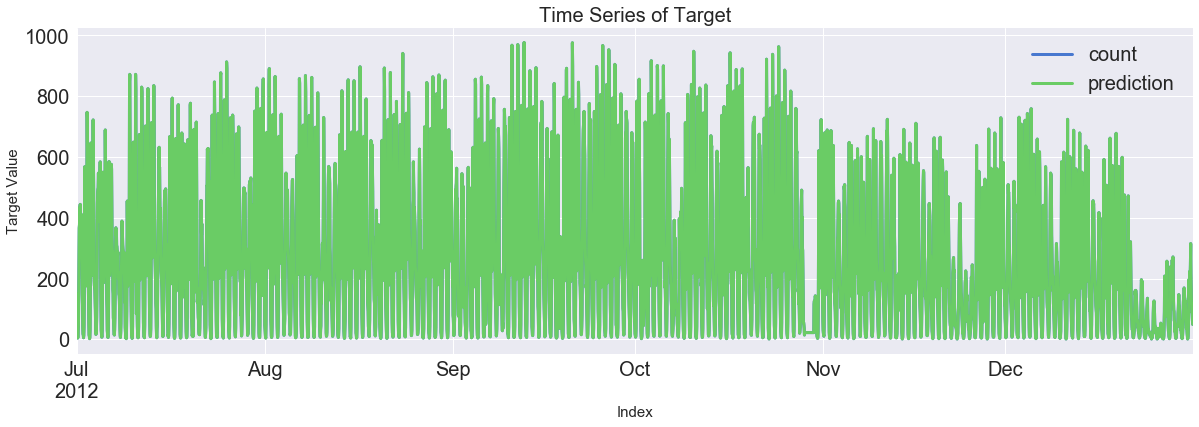

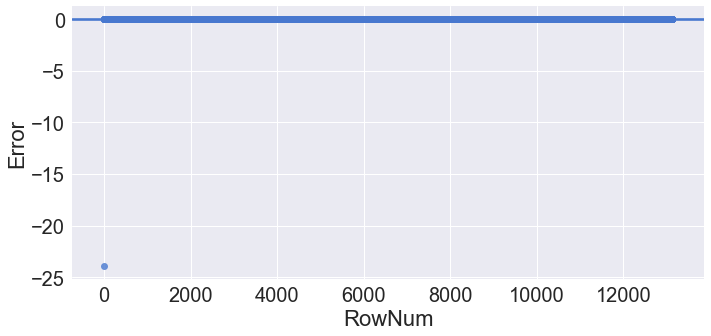

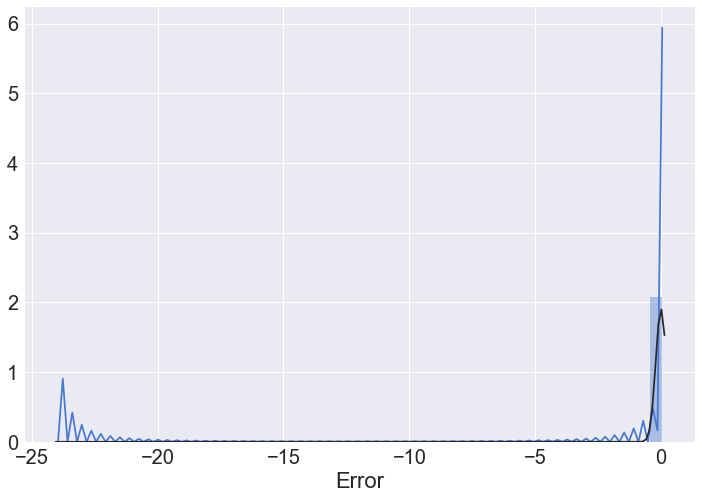

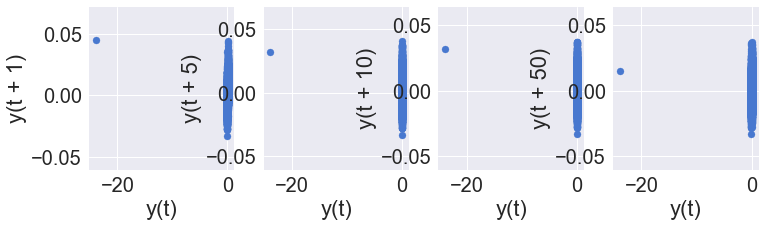

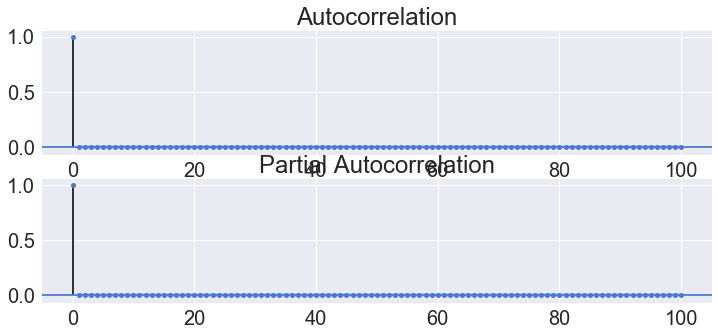

In [41]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = '../Data/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_fe, X_test_fe, Y_train_fe, Y_test_fe = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')

# Applying Base Model
fit_reg1_fe = sm.OLS(Y_train_fe, X_train_fe).fit()
display(fit_reg1_fe.summary())
pred_tr_reg1_fe = fit_reg1_fe.predict(X_train_fe).values
pred_te_reg1_fe = fit_reg1_fe.predict(X_test_fe).values

# Evaluation
Score_reg1_fe, Resid_tr_reg1_fe, Resid_te_reg1_fe = evaluation_trte(Y_train_fe, pred_tr_reg1_fe,
                                                                Y_test_fe, pred_te_reg1_fe, graph_on=True)
display(Score_reg1_fe)

# Error Analysis
error_analysis(Resid_tr_reg1_fe, ['Error'], X_train_fe, graph_on=True)

In [42]:
display(Score_reg1_rd)
display(Score_reg1_fe)

,MAE,MSE,MAPE
Train,103.09,"19,360.42",458.48
Test,150.03,"43,410.27",316.61


,MAE,MSE,MAPE
Train,0.01,0.04,0.06
Test,0.01,0.00,0.03


# Feature Engineering: 시간현실반영 / 변수간스케일조정 / 다중공선성제거

## 시간현실반영

In [43]:
raw_fe.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff,temp_group,Year,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,41.06,-134.25,41.04,56.11,24.00,"(8.856, 12.874]",2011,1,1,1,0,5,16.00,16.00,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,41.06,-154.75,41.04,56.11,24.00,"(8.856, 12.874]",2011,1,1,1,1,5,16.00,16.00,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,41.06,-165.27,41.04,56.11,-8.00,"(8.856, 12.874]",2011,1,1,1,2,5,40.00,16.00,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,41.06,-176.48,41.04,56.11,-19.00,"(8.856, 12.874]",2011,1,1,1,3,5,32.00,40.00,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,41.06,-181.67,41.04,56.11,-12.00,"(8.856, 12.874]",2011,1,1,1,4,5,13.00,32.00,0,0,0


In [44]:
# Test 기간의 FE데이터를 알 수 있을까?
# 1) 과거 패턴이 반복될 것이다
# 2) 하나씩 예측하며 업데이트

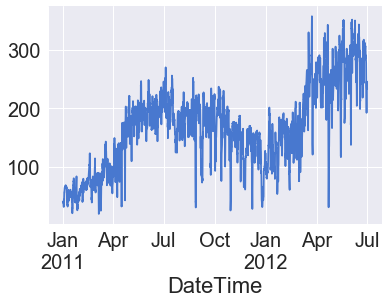

In [45]:
# count_trend
raw_fe.loc[X_train_fe.index, 'count_trend'].plot()
plt.show()

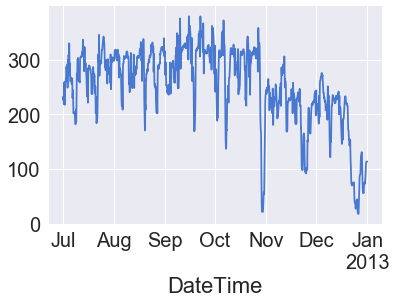

In [46]:
raw_fe.loc[X_test_fe.index, 'count_trend'].plot()
plt.show()

In [47]:
# raw_fe.loc['2012-01-01':'2012-12-31', 'count_trend'] = raw_fe.loc['2011-01-01':'2011-12-31', 'count_trend'].values
# raw_fe.loc['2012-01-01', 'count_trend']

In [48]:
# raw_fe.loc['2012-01-01':'2012-12-31', 'count_trend'].shape, raw_fe.loc['2011-01-01':'2011-12-31', 'count_trend'].shape

In [49]:
# raw_fe.loc['2012-02-29', 'count_trend']
# raw_fe.loc['2011-02-29', 'count_trend']

In [50]:
raw_fe.loc['2012-01-01':'2012-02-28', 'count_trend'] = raw_fe.loc['2011-01-01':'2011-02-28', 'count_trend'].values
raw_fe.loc['2012-03-01':'2012-12-31', 'count_trend'] = raw_fe.loc['2011-03-01':'2011-12-31', 'count_trend'].values
# 2012-02-29??
# raw_fe.loc['2012-02-27':'2012-03-03', 'count_trend']
# raw_fe.loc['2012-02-28':'2012-03-01', 'count_trend']
# raw_fe.loc['2012-02-28 23:00:00', 'count_trend']
# raw_fe.loc['2012-03-01 00:00:00', 'count_trend']
step = (raw_fe.loc['2011-03-01 00:00:00', 'count_trend'] - raw_fe.loc['2011-02-28 23:00:00', 'count_trend'])/25
step_value = np.arange(raw_fe.loc['2011-02-28 23:00:00', 'count_trend']+step, 
                       raw_fe.loc['2011-03-01 00:00:00', 'count_trend'], step)
step_value = step_value[:24]
raw_fe.loc['2012-02-29', 'count_trend'] = step_value

In [51]:
# raw_fe.loc['2012-02-28 22:00:00':'2012-03-01 02:00:00', 'count_trend']

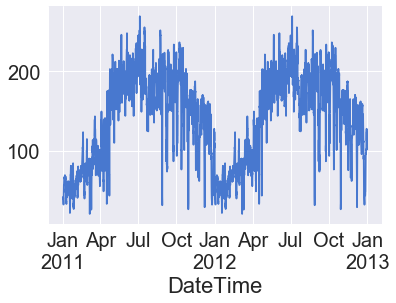

In [52]:
raw_fe['count_trend'].plot()

In [53]:
### Functionalize
### duplicate previous year values to next one
def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2012-01-01':'2012-02-28', col] = raw.loc['2011-01-01':'2011-02-28', col].values
        raw_fe.loc['2012-03-01':'2012-12-31', col] = raw.loc['2011-03-01':'2011-12-31', col].values
        step = (raw.loc['2011-03-01 00:00:00', col] - raw.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(raw.loc['2011-02-28 23:00:00', col]+step, raw.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        raw_fe.loc['2012-02-29', col] = step_value
    return raw_fe
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_fe = feature_engineering_year_duplicated(raw_fe, target)

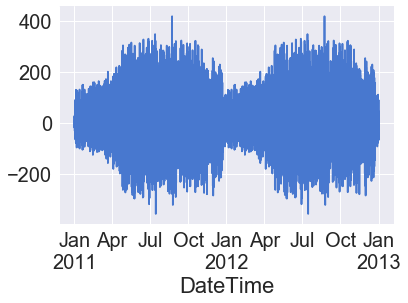

In [54]:
raw_fe['count_diff'].plot()

In [55]:
# count_lag1, count_lag2
raw_fe.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff,temp_group,Year,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,41.06,-134.25,41.04,56.11,24.00,"(8.856, 12.874]",2011,1,1,1,0,5,16.00,16.00,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,41.06,-154.75,41.04,56.11,24.00,"(8.856, 12.874]",2011,1,1,1,1,5,16.00,16.00,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,41.06,-165.27,41.04,56.11,-8.00,"(8.856, 12.874]",2011,1,1,1,2,5,40.00,16.00,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,41.06,-176.48,41.04,56.11,-19.00,"(8.856, 12.874]",2011,1,1,1,3,5,32.00,40.00,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,41.06,-181.67,41.04,56.11,-12.00,"(8.856, 12.874]",2011,1,1,1,4,5,13.00,32.00,0,0,0


In [56]:
X_test_fe['count_lag1'] = Y_test_fe.shift(1).values
X_test_fe['count_lag1'].fillna(method='bfill', inplace=True)
X_test_fe['count_lag2'] = Y_test_fe.shift(2).values
X_test_fe['count_lag2'].fillna(method='bfill', inplace=True)
X_test_fe['count_lag2']

DateTime
2012-07-01 00:00:00   149.00
2012-07-01 01:00:00   149.00
2012-07-01 02:00:00   149.00
2012-07-01 03:00:00    93.00
2012-07-01 04:00:00    90.00
2012-07-01 05:00:00    33.00
2012-07-01 06:00:00     4.00
2012-07-01 07:00:00    10.00
2012-07-01 08:00:00    27.00
2012-07-01 09:00:00    50.00
2012-07-01 10:00:00   142.00
2012-07-01 11:00:00   219.00
2012-07-01 12:00:00   366.00
2012-07-01 13:00:00   377.00
2012-07-01 14:00:00   433.00
2012-07-01 15:00:00   420.00
2012-07-01 16:00:00   444.00
2012-07-01 17:00:00   345.00
2012-07-01 18:00:00   313.00
2012-07-01 19:00:00   413.00
2012-07-01 20:00:00   370.00
2012-07-01 21:00:00   382.00
2012-07-01 22:00:00   332.00
2012-07-01 23:00:00   258.00
2012-07-02 00:00:00   151.00
                       ...  
2012-12-30 23:00:00    47.00
2012-12-31 00:00:00    36.00
2012-12-31 01:00:00    49.00
2012-12-31 02:00:00    34.00
2012-12-31 03:00:00    19.00
2012-12-31 04:00:00    11.00
2012-12-31 05:00:00     1.00
2012-12-31 06:00:00     3.00
2012-

In [57]:
### Functionalize
### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm
target = ['count_lag1', 'count_lag2']
X_test_fe = feature_engineering_lag_modified(Y_test_fe, X_test_fe, target)

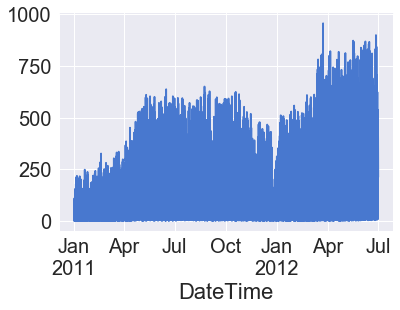

In [58]:
X_train_fe['count_lag2'].plot()

### Code Summary (Reality)

In [59]:
### Functionalize
### duplicate previous year values to next one
def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2012-01-01':'2012-02-28', col] = raw.loc['2011-01-01':'2011-02-28', col].values
        raw_fe.loc['2012-03-01':'2012-12-31', col] = raw.loc['2011-03-01':'2011-12-31', col].values
        step = (raw.loc['2011-03-01 00:00:00', col] - raw.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(raw.loc['2011-02-28 23:00:00', col]+step, raw.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        raw_fe.loc['2012-02-29', col] = step_value
    return raw_fe
# target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
# raw_fe = feature_engineering_year_duplicated(raw_fe, target)

### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm
# target = ['count_lag1', 'count_lag2']
# X_test_fe = feature_engineering_lag_modified(Y_test_fe, X_test_fe, target)

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     5658.
Date:                Wed, 13 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:40:32   Log-Likelihood:                -69618.
No. Observations:               13128   AIC:                         1.393e+05
Df Residuals:                   13104   BIC:                         1.395e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season             2.7535      0.952      2.893      0.004       0.888       4.619
holiday            0.6180      3.170      0.195      0.845      -5.595       6.831
workingday         2.1960      1.544      1.423      0.155      -0.830       5.222
weather           -5.8817      0.780     -7.544      0.000      -7.410      -4.353
temp               0.5622      0.490      1.146      0.252      -0.399       1.523
atemp              0.4042      0.427      0.946      0.344      -0.433       1.242
humidity          -0.0706      0.028     -2.501      0.012      -0.126      -0.015
windspeed         -0.1216      0.057     -2.117      0.034      -0.234      -0.009
count_trend        0.0718      0.024      3.007      0.003       0.025       0.119
count_seasonal     0.1948      0.006     34.600      0.000       0.184       0.206
count_Day          0.1011      0.024      4.190      0.000       0.054       0.148
count_Week        -0.0801      0.026     -3.078      0.002      -0.131      -0.029
count_diff         0.7146      0.007     97.737      0.000       0.700       0.729
Year               0.0004      0.002      0.188      0.851      -0.003       0.004
Quater_ver2        5.6849      0.284     19.988      0.000       5.127       6.242
Month              1.1013      0.566      1.945      0.052      -0.009       2.211
Day               -0.0335      0.049     -0.681      0.496      -0.130       0.063
Hour               0.1185      0.083      1.420      0.156      -0.045       0.282
DayofWeek          0.3611      0.354      1.021      0.307      -0.332       1.055
count_lag1         0.9285      0.006    149.851      0.000       0.916       0.941
count_lag2        -0.1938      0.006    -33.734      0.000      -0.205      -0.183
Quater_Dummy_2    -7.2671      2.213     -3.284      0.001     -11.605      -2.929
Quater_Dummy_3   -21.5188      3.728     -5.773      0.000     -28.825     -14.212
Quater_Dummy_4   -26.7509      5.511     -4.854      0.000     -37.554     -15.948
==============================================================================
Omnibus:                     3715.248   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115549.958
Skew:                           0.728   Prob(JB):                         0.00
Kurtosis:                      17.461   Cond. No.                     3.22e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,MAE,MSE,MAPE
Train,27.79,"2,364.05",82.11
Test,113.99,"26,316.17",133.61


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-13.45,0.78,572.93,744.23,"2,927.28","7,390.92","46,108.47"
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"133,771.72",nan,nan,nan,nan,nan,NaN


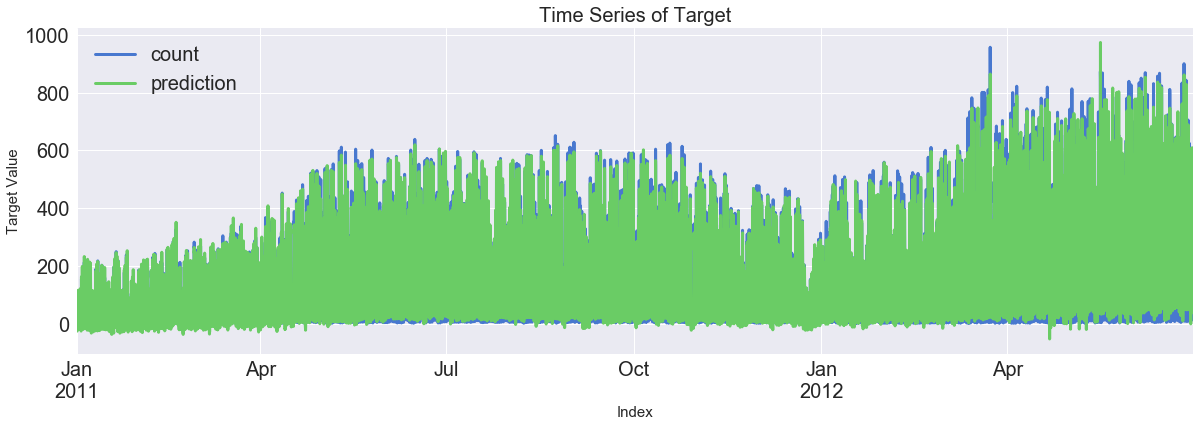

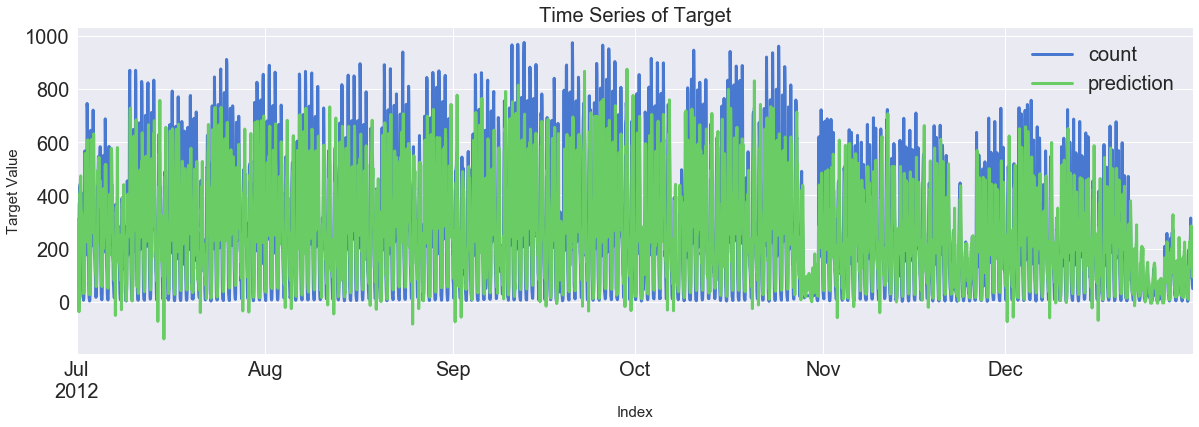

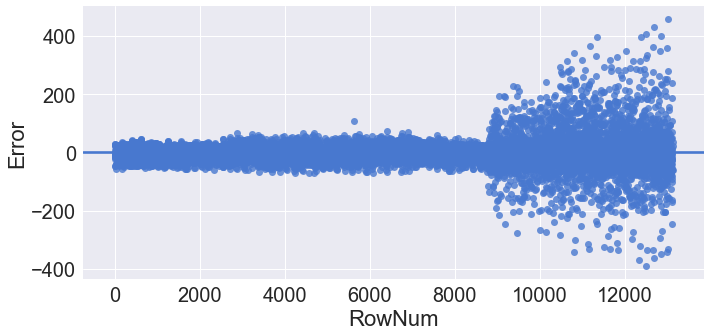

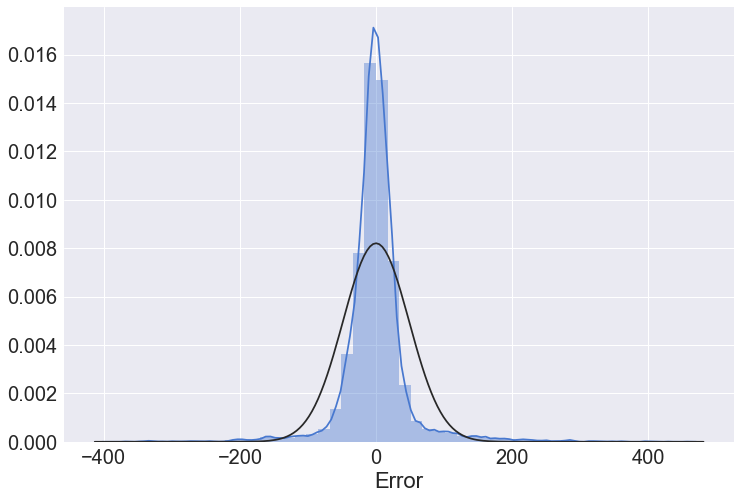

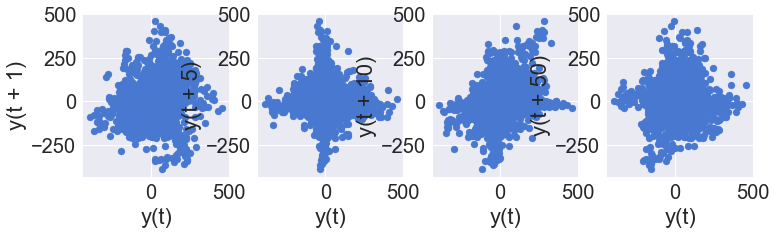

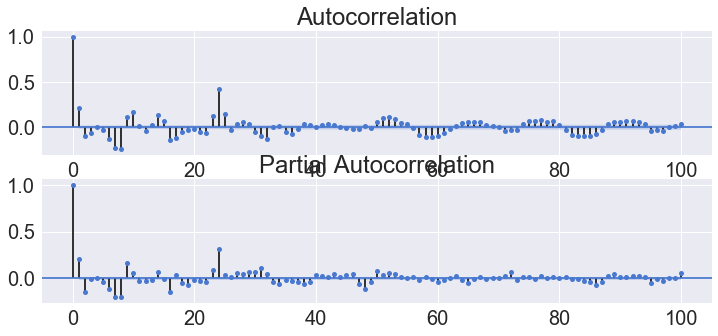

In [60]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = '../Data/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############

# Applying Base Model
fit_reg1_feR = sm.OLS(Y_train_feR, X_train_feR).fit()
display(fit_reg1_feR.summary())
pred_tr_reg1_feR = fit_reg1_feR.predict(X_train_feR).values
pred_te_reg1_feR = fit_reg1_feR.predict(X_test_feR).values

# Evaluation
Score_reg1_feR, Resid_tr_reg1_feR, Resid_te_reg1_feR = evaluation_trte(Y_train_feR, pred_tr_reg1_feR,
                                                                   Y_test_feR, pred_te_reg1_feR, graph_on=True)
display(Score_reg1_feR)

# Error Analysis
error_analysis(Resid_tr_reg1_feR, ['Error'], X_train_feR, graph_on=True)

In [61]:
display(Score_reg1_rd)
display(Score_reg1_fe)
display(Score_reg1_feR)

,MAE,MSE,MAPE
Train,103.09,"19,360.42",458.48
Test,150.03,"43,410.27",316.61


,MAE,MSE,MAPE
Train,0.01,0.04,0.06
Test,0.01,0.00,0.03


,MAE,MSE,MAPE
Train,27.79,"2,364.05",82.11
Test,113.99,"26,316.17",133.61


## 변수간스케일조정

In [62]:
scaler = preprocessing.MinMaxScaler()
scaler_fit = scaler.fit(X_train_feR)
X_train_feRS = pd.DataFrame(scaler_fit.transform(X_train_feR), 
                           index=X_train_feR.index, columns=X_train_feR.columns)
X_test_feRS = pd.DataFrame(scaler_fit.transform(X_test_feR), 
                           index=X_test_feR.index, columns=X_test_feR.columns)

### Code Summary (Scaling)

In [63]:
### Functionalize
### scaling of X_train and X_test by X_train_scaler
def feature_engineering_scaling(scaler, X_train, X_test):
    # preprocessing.MinMaxScaler()
    # preprocessing.StandardScaler()
    # preprocessing.RobustScaler()
    # preprocessing.Normalizer()
    scaler = scaler
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                               index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                               index=X_test.index, columns=X_test.columns)
    return X_train_scaling, X_test_scaling
# X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                 1.201e+04
Date:                Wed, 13 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:40:48   Log-Likelihood:                -69508.
No. Observations:               13128   AIC:                         1.391e+05
Df Residuals:                   13104   BIC:                         1.392e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season          4315.6193   1933.052      2.233      0.026     526.557    8104.681
holiday         -409.2134   6443.851     -0.064      0.949    -1.3e+04    1.22e+04
workingday      2915.8573   3150.917      0.925      0.355   -3260.397    9092.112
weather        -1.105e+04   1587.055     -6.965      0.000   -1.42e+04   -7943.631
temp            1593.7972   1005.124      1.586      0.113    -376.391    3563.986
atemp            112.3002    874.853      0.128      0.898   -1602.538    1827.138
humidity        -112.4943     57.480     -1.957      0.050    -225.163       0.174
windspeed       -241.9981    117.465     -2.060      0.039    -472.246     -11.750
count_trend      119.3792     48.631      2.455      0.014      24.055     214.703
count_seasonal   356.4902     11.505     30.985      0.000     333.938     379.042
count_Day        203.8292     49.125      4.149      0.000     107.538     300.120
count_Week      -114.3462     53.135     -2.152      0.031    -218.499     -10.194
count_diff      1524.5914     15.184    100.410      0.000    1494.829    1554.354
Year              -2.3743      3.796     -0.626      0.532      -9.815       5.066
Quater_ver2     1.118e+04    578.212     19.343      0.000    1.01e+04    1.23e+04
Month           2308.4692   1155.318      1.998      0.046      43.878    4573.060
Day              -42.2992    100.152     -0.422      0.673    -238.611     154.013
Hour             -88.0027    169.788     -0.518      0.604    -420.811     244.806
DayofWeek        298.0309    722.036      0.413      0.680   -1117.264    1713.326
count_lag1      2036.3774     12.950    157.255      0.000    2010.994    2061.760
count_lag2      -384.2636     12.038    -31.921      0.000    -407.859    -360.668
Quater_Dummy_2 -1.317e+04   4509.968     -2.919      0.004    -2.2e+04   -4325.329
Quater_Dummy_3 -4.321e+04   7615.435     -5.674      0.000   -5.81e+04   -2.83e+04
Quater_Dummy_4 -5.415e+04   1.13e+04     -4.810      0.000   -7.62e+04   -3.21e+04
==============================================================================
Omnibus:                     3787.573   Durbin-Watson:                   1.578
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           125389.728
Skew:                           0.737   Prob(JB):                         0.00
Kurtosis:                      18.069   Cond. No.                     3.22e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,MAE,MSE,MAPE
Train,27.18,"2,324.78",80.36
Test,113.06,"25,908.84",129.35


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-13.69,0.78,585.36,715.46,"2,798.72","7,261.76",477.22
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,40.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,087.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"133,677.59",nan,nan,nan,nan,nan,NaN


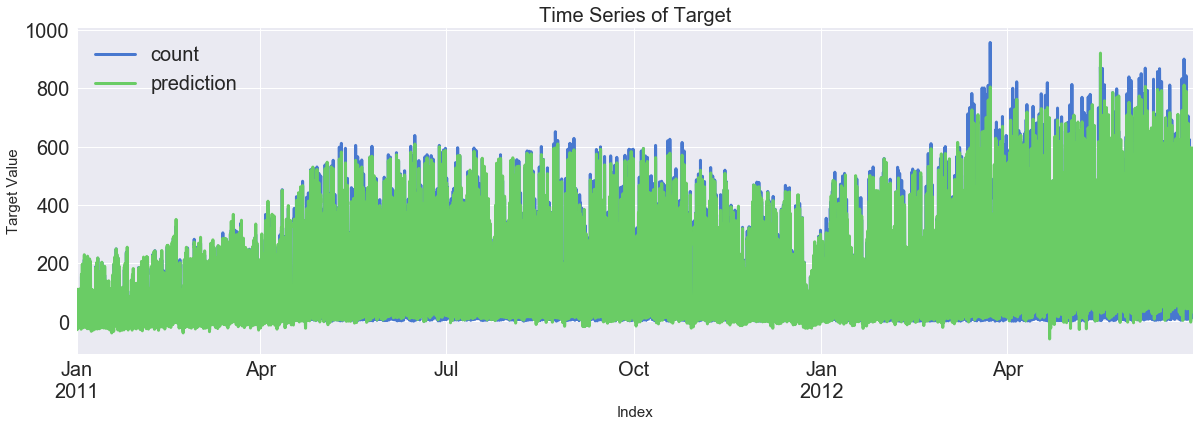

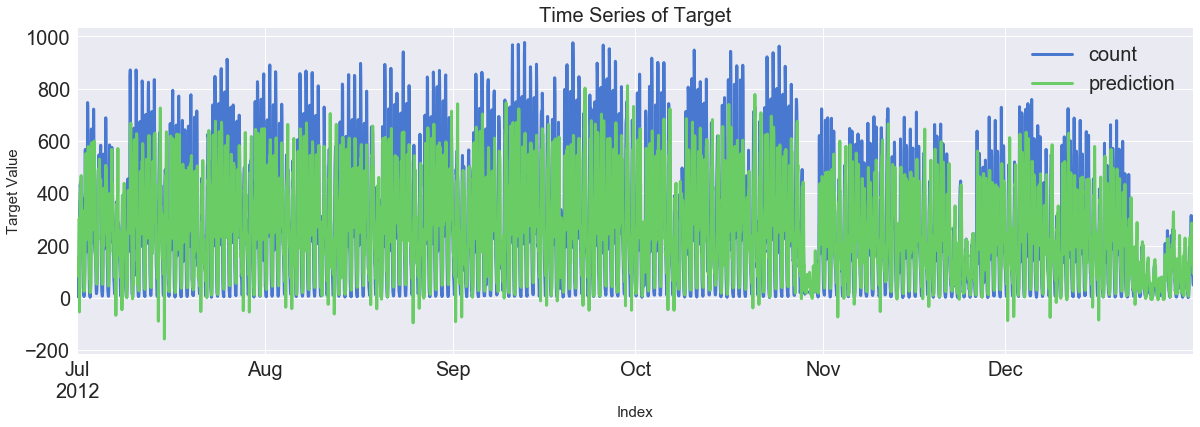

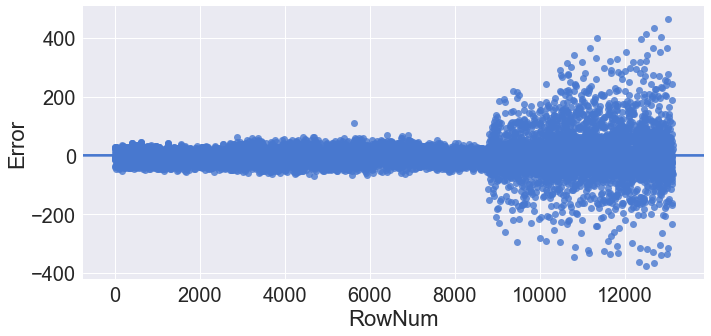

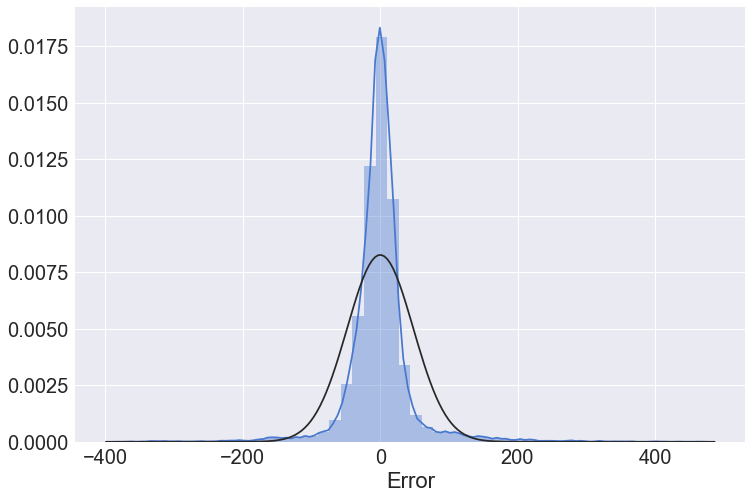

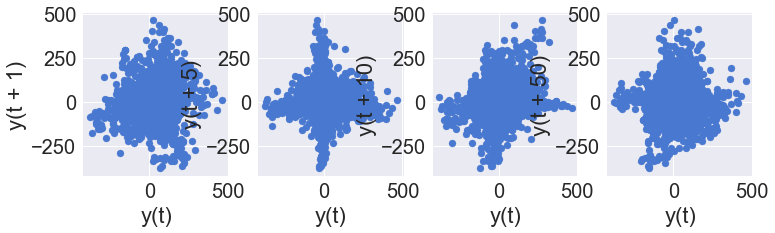

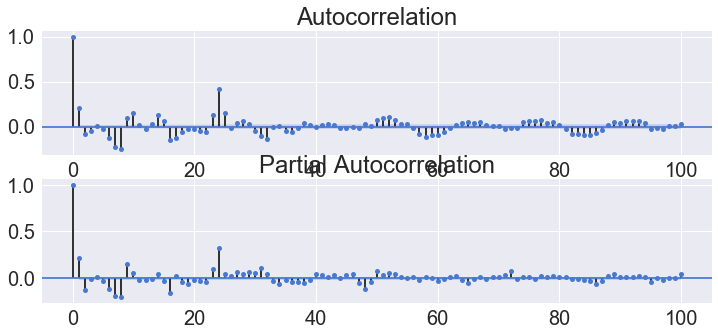

In [64]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = '../Data/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############

# Applying Base Model
fit_reg1_feRS = sm.OLS(Y_train_feR, X_train_feRS).fit()
display(fit_reg1_feRS.summary())
pred_tr_reg1_feRS = fit_reg1_feRS.predict(X_train_feRS).values
pred_te_reg1_feRS = fit_reg1_feRS.predict(X_test_feRS).values

# Evaluation
Score_reg1_feRS, Resid_tr_reg1_feRS, Resid_te_reg1_feRS = evaluation_trte(Y_train_feR, pred_tr_reg1_feRS,
                                                                   Y_test_feR, pred_te_reg1_feRS, graph_on=True)
display(Score_reg1_feRS)

# Error Analysis
error_analysis(Resid_tr_reg1_feRS, ['Error'], X_train_feRS, graph_on=True)

In [65]:
display(Score_reg1_rd)
display(Score_reg1_fe)
display(Score_reg1_feR)
display(Score_reg1_feRS)


,MAE,MSE,MAPE
Train,103.09,"19,360.42",458.48
Test,150.03,"43,410.27",316.61


,MAE,MSE,MAPE
Train,0.01,0.04,0.06
Test,0.01,0.00,0.03


,MAE,MSE,MAPE
Train,27.79,"2,364.05",82.11
Test,113.99,"26,316.17",133.61


,MAE,MSE,MAPE
Train,27.18,"2,324.78",80.36
Test,113.06,"25,908.84",129.35


## 다중공선성제거

In [66]:
raw_feR.corr().loc[:, ['casual', 'registered', 'count']].style.background_gradient().set_precision(2).set_properties(**{'font-size': '11pt'})
# count_trend, count_seasonal, count_Day, count_Week, count_diff, Hour, count_lag1, count_lag2

,casual,registered,count
season,0.12,0.18,0.18
holiday,0.027,-0.052,-0.036
workingday,-0.3,0.13,0.03
weather,-0.16,-0.13,-0.15
temp,0.46,0.34,0.41
atemp,0.46,0.34,0.41
humidity,-0.35,-0.28,-0.33
windspeed,0.082,0.072,0.083
casual,1,0.51,0.7
registered,0.51,1,0.97


In [67]:
# for col in raw_feR.describe().columns:
#     target = raw_feR[col]
# #     figure, axes = plt.subplots(2,1,figsize=(16,10))
# #     sm.graphics.tsa.plot_acf(target, lags=100, use_vlines=True, ax=axes[0], title=col)
# #     sm.graphics.tsa.plot_pacf(target, lags=100, use_vlines=True, ax=axes[1], title=col)  
#     figure, axes = plt.subplots(1,1,figsize=(16,5))
# #     sm.graphics.tsa.plot_acf(target, lags=100, use_vlines=True, ax=axes, title=col)
#     sm.graphics.tsa.plot_pacf(target, lags=100, use_vlines=True, ax=axes, title=col)
# # count_trend, count_seasonal, count_Day, count_Week, count_diff, Hour, DayofWeek, count_lag1, count_lag2

In [68]:
raw_feR.corr().loc[X_colname, X_colname].style.background_gradient().set_precision(2).set_properties(**{'font-size': '11pt'})

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count_trend,count_seasonal,count_Day,count_Week,count_diff,Year,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
season,1,-0.019,0.015,-0.015,0.32,0.33,0.15,-0.14,0.55,0.0017,0.55,0.63,0.00071,-0.0018,0.42,0.83,-0.0007,-0.0081,-0.0073,0.18,0.18,-0.2,0.31,0.6
holiday,-0.019,1,-0.26,-0.004,-0.036,-0.041,-0.0056,0.0097,-0.067,-0.0046,-0.058,-0.021,-0.0013,0.0018,0.013,0.0098,-0.0087,0.0097,-0.19,-0.035,-0.036,-0.026,-0.027,0.047
workingday,0.015,-0.26,1,0.044,0.054,0.053,0.016,-0.016,0.025,0.00091,0.028,0.013,0.00061,0.0002,-0.0045,-0.0026,0.0091,-0.0041,-0.7,0.026,0.022,0.012,0.009,-0.018
weather,-0.015,-0.004,0.044,1,-0.11,-0.11,0.43,0.049,-0.18,-0.0036,-0.12,-0.061,-0.0089,-0.022,-0.02,0.00089,0.01,-0.022,-0.057,-0.14,-0.14,-0.027,-0.067,0.053
temp,0.32,-0.036,0.054,-0.11,1,0.99,-0.074,-0.024,0.7,0.17,0.71,0.77,0.00078,0.047,0.14,0.21,0.024,0.14,-0.03,0.41,0.4,0.26,0.6,-0.31
atemp,0.33,-0.041,0.053,-0.11,0.99,1,-0.057,-0.064,0.7,0.16,0.71,0.76,-0.002,0.046,0.15,0.22,0.018,0.13,-0.032,0.41,0.4,0.27,0.58,-0.29
humidity,0.15,-0.0056,0.016,0.43,-0.074,-0.057,1,-0.27,0.014,-0.34,0.039,0.13,-0.0065,-0.085,0.0018,0.16,0.034,-0.27,-0.041,-0.33,-0.31,-0.03,0.064,0.1
windspeed,-0.14,0.0097,-0.016,0.049,-0.024,-0.064,-0.27,1,-0.16,0.19,-0.16,-0.13,0.016,-0.013,-0.074,-0.13,0.021,0.14,-0.00035,0.079,0.062,0.044,-0.1,-0.058
count_trend,0.55,-0.067,0.025,-0.18,0.7,0.7,0.014,-0.16,1,0.0023,0.93,0.86,0.0014,-0.002,0.22,0.45,-0.0051,-0.0021,-0.0014,0.3,0.3,0.3,0.43,0.001
count_seasonal,0.0017,-0.0046,0.00091,-0.0036,0.17,0.16,-0.34,0.19,0.0023,1,0.0025,0.0019,0.2,-0.0012,-0.00027,0.0016,-0.0017,0.55,0.0016,0.6,0.41,0.00072,0.00072,0.00072


In [69]:
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(X_train_feRS.values, i) 
                     for i in range(X_train_feRS.shape[1])]
vif['Feature'] = X_train_feRS.columns
vif.sort_values(by='VIF_Factor', ascending=True)

,VIF_Factor,Feature
12,1.56,count_diff
1,1.61,holiday
9,2.89,count_seasonal
16,4.32,Day
7,4.51,windspeed
14,6.69,Quater_ver2
17,6.87,Hour
3,8.38,weather
21,8.83,Quater_Dummy_2
18,9.03,DayofWeek


### Code Summary (Multicollinearity)

In [85]:
### Functionalize
### extract non-multicollinearity variables by VIF 
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif
# X_colname_vif = feature_engineering_XbyVIF(X_train_femm, 10)
# X_colname_vif

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:13<00:00,  1.91it/s]


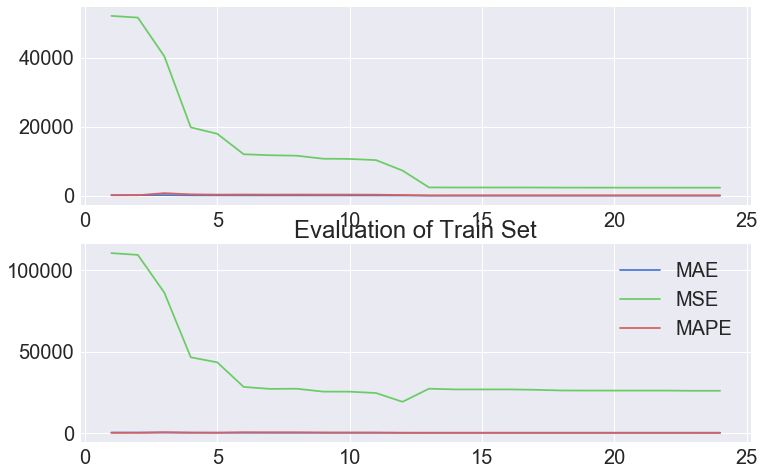

In [129]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = '../Data/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

eval_tr = pd.DataFrame()
eval_te = pd.DataFrame()
for i in tqdm(range(1,len(X_train_feRS.columns)+1)):
    X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, i)
#     print('Number_of_Selected_X: ', len(X_colname_vif))
    X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
    
    # Applying Base Model
    fit_reg1_feRSM = sm.OLS(Y_train_feR, X_train_feRSM).fit()
    pred_tr_reg1_feRSM = fit_reg1_feRSM.predict(X_train_feRSM).values
    pred_te_reg1_feRSM = fit_reg1_feRSM.predict(X_test_feRSM).values

    # Evaluation
    Score_reg1_feRSM, Resid_tr_reg1_feRSM, Resid_te_reg1_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg1_feRSM,
                                                                       Y_test_feR, pred_te_reg1_feRSM, graph_on=False)
    eval_tr = pd.concat([eval_tr, Score_reg1_feRSM.loc[['Train']]], axis=0)
    eval_te = pd.concat([eval_te, Score_reg1_feRSM.loc[['Test']]], axis=0)
eval_tr.index = range(1,len(X_train_feRS.columns)+1)
eval_te.index = range(1,len(X_train_feRS.columns)+1)

fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(eval_tr.index, eval_tr)
plt.legend(eval_tr.columns)
plt.title('Evaluation of Train Set')
ax[1].plot(eval_te.index, eval_te)
plt.legend(eval_te.columns)
plt.title('Evaluation of Train Set')
plt.show()

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     6925.
Date:                Wed, 13 Mar 2019   Prob (F-statistic):               0.00
Time:                        23:57:57   Log-Likelihood:                -77008.
No. Observations:               13128   AIC:                         1.540e+05
Df Residuals:                   13116   BIC:                         1.541e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
count_diff      1289.2806     25.881     49.816      0.000    1238.550    1340.011
holiday         7.141e+04   1.01e+04      7.044      0.000    5.15e+04    9.13e+04
count_seasonal  1270.9307     16.107     78.906      0.000    1239.359    1302.503
Day             1151.2606    168.230      6.843      0.000     821.505    1481.017
windspeed       -234.1084    180.733     -1.295      0.195    -588.370     120.154
Quater_ver2     2.865e+04    930.475     30.787      0.000    2.68e+04    3.05e+04
Hour           -3514.0425    282.316    -12.447      0.000   -4067.422   -2960.663
weather        -2.423e+04   2238.550    -10.825      0.000   -2.86e+04   -1.98e+04
Quater_Dummy_2  6.725e+04   3436.993     19.566      0.000    6.05e+04     7.4e+04
DayofWeek       1.621e+04    912.387     17.768      0.000    1.44e+04     1.8e+04
workingday      7.695e+04   4056.717     18.970      0.000     6.9e+04    8.49e+04
count_lag2      1061.0008     14.379     73.788      0.000    1032.816    1089.186
==============================================================================
Omnibus:                     1665.324   Durbin-Watson:                   0.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5853.426
Skew:                           0.626   Prob(JB):                         0.00
Kurtosis:                       6.022   Cond. No.                     1.53e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,MAE,MSE,MAPE
Train,60.84,"7,288.40",202.42
Test,99.87,"19,151.40",153.34


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-10.30,0.95,"4,492.76","4,708.56","7,076.59","16,328.78",2.71
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"140,733.05",nan,nan,nan,nan,nan,NaN


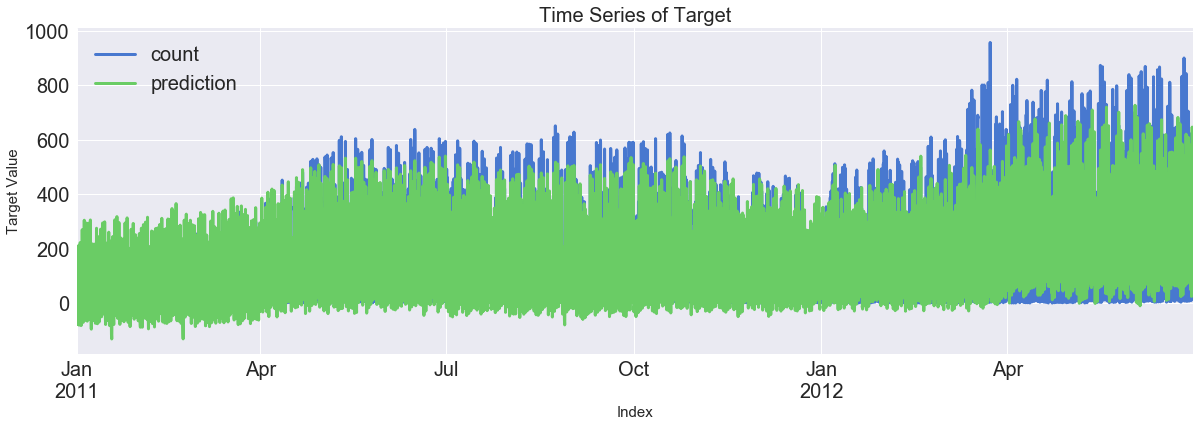

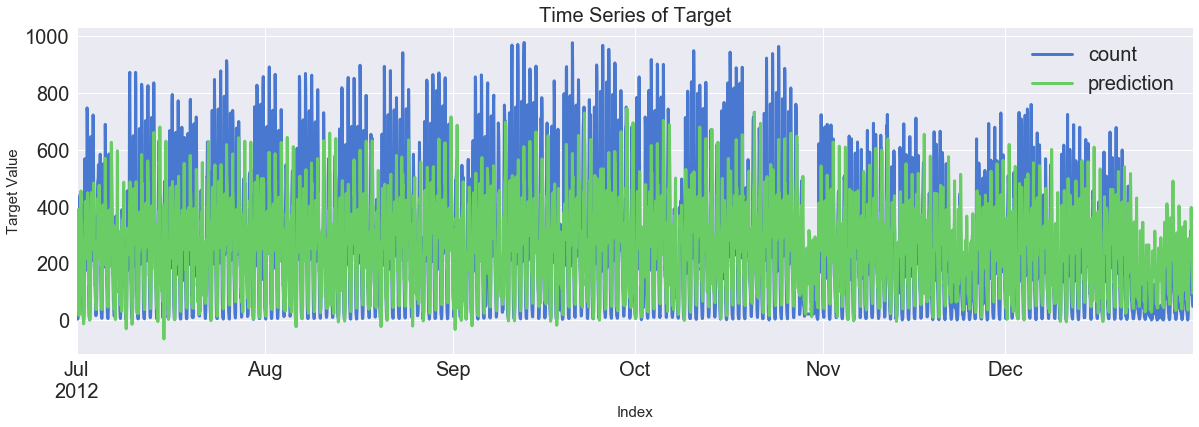

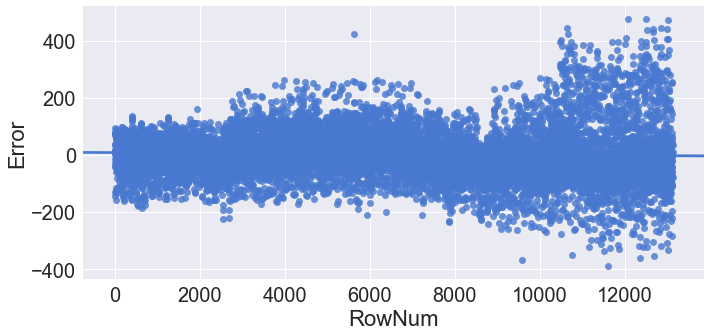

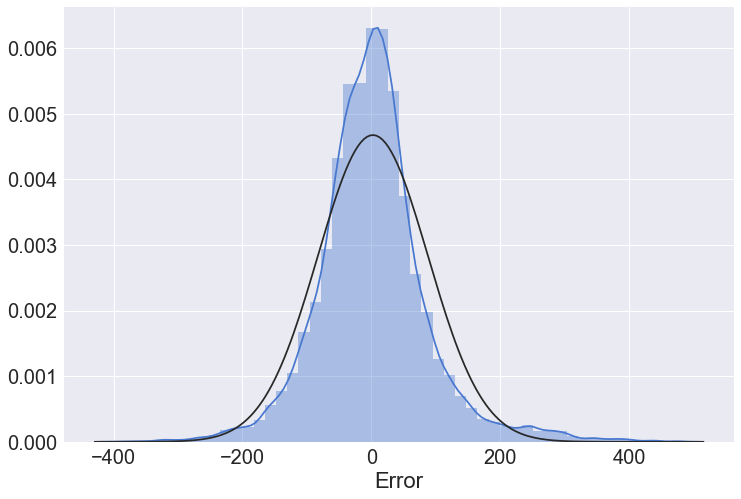

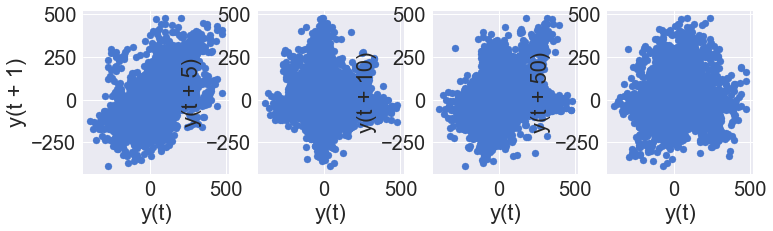

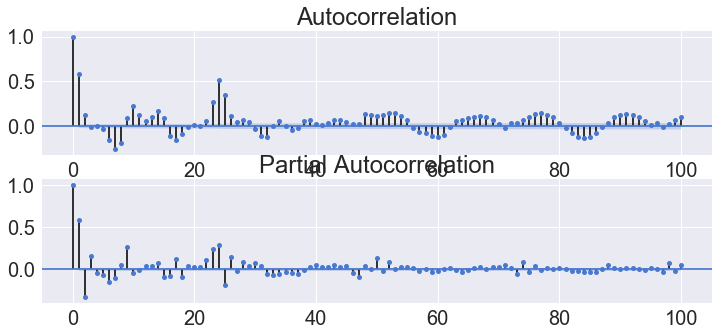

In [130]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = '../Data/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

# Applying Base Model
fit_reg1_feRSM = sm.OLS(Y_train_feR, X_train_feRSM).fit()
display(fit_reg1_feRSM.summary())
pred_tr_reg1_feRSM = fit_reg1_feRSM.predict(X_train_feRSM).values
pred_te_reg1_feRSM = fit_reg1_feRSM.predict(X_test_feRSM).values

# Evaluation
Score_reg1_feRSM, Resid_tr_reg1_feRSM, Resid_te_reg1_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg1_feRSM,
                                                                   Y_test_feR, pred_te_reg1_feRSM, graph_on=True)
display(Score_reg1_feRSM)

# Error Analysis
error_analysis(Resid_tr_reg1_feRSM, ['Error'], X_train_feRSM, graph_on=True)

# Final Result Comparison: 전처리(Raw/Reality/Scaling/Multicollinearity) 별 결과비교

In [131]:
display(Score_reg1_rd)
display(Score_reg1_feR)
display(Score_reg1_feRS)
display(Score_reg1_feRSM)

,MAE,MSE,MAPE
Train,103.09,"19,360.42",458.48
Test,150.03,"43,410.27",316.61


,MAE,MSE,MAPE
Train,27.79,"2,364.05",82.11
Test,113.99,"26,316.17",133.61


,MAE,MSE,MAPE
Train,27.18,"2,324.78",80.36
Test,113.06,"25,908.84",129.35


,MAE,MSE,MAPE
Train,60.84,"7,288.40",202.42
Test,99.87,"19,151.40",153.34


In [132]:
comparison_r2 = pd.DataFrame([fit_reg1_rd.rsquared_adj, fit_reg1_feR.rsquared_adj, 
                              fit_reg1_feRS.rsquared_adj, fit_reg1_feRSM.rsquared_adj], 
                             index=['rd', 'feR', 'feRS', 'feRSM'], columns=['R^2_adj']).T
comparison_fvalue = pd.DataFrame([fit_reg1_rd.fvalue, fit_reg1_feR.fvalue, 
                                  fit_reg1_feRS.fvalue, fit_reg1_feRSM.fvalue], 
                                 index=['rd', 'feR', 'feRS', 'feRSM'], columns=['F-statistics']).T
comparison_fpvalue = pd.DataFrame([fit_reg1_rd.f_pvalue, fit_reg1_feR.f_pvalue, 
                                   fit_reg1_feRS.f_pvalue, fit_reg1_feRSM.f_pvalue], 
                                  index=['rd', 'feR', 'feRS', 'feRSM'], columns=['prob(F-stat.)']).T
comparison_aic = pd.DataFrame([fit_reg1_rd.aic, fit_reg1_feR.aic, 
                              fit_reg1_feRS.aic, fit_reg1_feRSM.aic], 
                             index=['rd', 'feR', 'feRS', 'feRSM'], columns=['aic']).T
comparison_bic = pd.DataFrame([fit_reg1_rd.bic, fit_reg1_feR.bic, 
                               fit_reg1_feRS.bic, fit_reg1_feRSM.bic], 
                              index=['rd', 'feR', 'feRS', 'feRSM'], columns=['bic']).T
pd.concat([comparison_r2, comparison_fvalue, comparison_fpvalue, comparison_aic, comparison_bic], axis=0)

,rd,feR,feRS,feRSM
R^2_adj,0.64,0.91,0.96,0.86
F-statistics,"2,889.02","5,657.99","12,011.02","6,924.95"
prob(F-stat.),0.00,0.00,0.00,0.00
aic,"166,857.95","139,283.69","139,063.76","154,040.60"
bic,"166,917.81","139,463.27","139,243.34","154,130.39"


In [133]:
comparison_fit_rd = pd.concat([pd.DataFrame(fit_reg1_rd.params, columns=['coef']), 
                               pd.DataFrame(fit_reg1_rd.pvalues, columns=['prob(coef)'])], axis=1)
comparison_fit_feR = pd.concat([pd.DataFrame(fit_reg1_feR.params, columns=['coef']), 
                               pd.DataFrame(fit_reg1_feR.pvalues, columns=['prob(coef)'])], axis=1)
comparison_fit_feRS = pd.concat([pd.DataFrame(fit_reg1_feRS.params, columns=['coef']), 
                               pd.DataFrame(fit_reg1_feRS.pvalues, columns=['prob(coef)'])], axis=1)
comparison_fit_feRSM = pd.concat([pd.DataFrame(fit_reg1_feRSM.params, columns=['coef']), 
                               pd.DataFrame(fit_reg1_feRSM.pvalues, columns=['prob(coef)'])], axis=1)
pd.concat([comparison_fit_rd, comparison_fit_feR, comparison_fit_feRS, comparison_fit_feRSM], axis=1)

,coef,prob(coef),coef,prob(coef),coef,prob(coef),coef,prob(coef)
Day,nan,nan,-0.03,0.50,-42.30,0.67,"1,151.26",0.00
DayofWeek,nan,nan,0.36,0.31,298.03,0.68,"16,211.12",0.00
Hour,nan,nan,0.12,0.16,-88.00,0.60,"-3,514.04",0.00
Month,nan,nan,1.10,0.05,"2,308.47",0.05,nan,nan
Quater_Dummy_2,nan,nan,-7.27,0.00,"-13,165.52",0.00,"67,249.49",0.00
Quater_Dummy_3,nan,nan,-21.52,0.00,"-43,207.92",0.00,nan,nan
Quater_Dummy_4,nan,nan,-26.75,0.00,"-54,152.60",0.00,nan,nan
Quater_ver2,nan,nan,5.68,0.00,"11,184.46",0.00,"28,646.27",0.00
Year,nan,nan,0.00,0.85,-2.37,0.53,nan,nan
atemp,16.07,0.00,0.40,0.34,112.30,0.90,nan,nan


In [134]:
display(error_analysis(Resid_tr_reg1_rd, ['Error'], X_train_feRSM, graph_on=False))
display(error_analysis(Resid_tr_reg1_feR, ['Error'], X_train_feRSM, graph_on=False))
display(error_analysis(Resid_tr_reg1_feRS, ['Error'], X_train_feRSM, graph_on=False))
display(error_analysis(Resid_tr_reg1_feRSM, ['Error'], X_train_feRSM, graph_on=False))

,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.25,0.94,"8,204.84","12,494.43","13,138.03","48,485.56",1.62
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,40.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,087.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"143,252.82",nan,nan,nan,nan,nan,NaN


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-13.45,0.78,572.93,744.23,"2,927.28","7,390.92",64.44
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"133,771.72",nan,nan,nan,nan,nan,NaN


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-13.69,0.78,585.36,715.46,"2,798.72","7,261.76",67.59
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,40.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,087.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"133,677.59",nan,nan,nan,nan,nan,NaN


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-10.30,0.95,"4,492.76","4,708.56","7,076.59","16,328.78",2.71
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"140,733.05",nan,nan,nan,nan,nan,NaN


# Applying Base Model: Y예측을 위한 Agile(ML)분석 실행

In [135]:
display(Score_reg1_rd)
display(Score_reg1_feR)
display(Score_reg1_feRS)
display(Score_reg1_feRSM)

,MAE,MSE,MAPE
Train,103.09,"19,360.42",458.48
Test,150.03,"43,410.27",316.61


,MAE,MSE,MAPE
Train,27.79,"2,364.05",82.11
Test,113.99,"26,316.17",133.61


,MAE,MSE,MAPE
Train,27.18,"2,324.78",80.36
Test,113.06,"25,908.84",129.35


,MAE,MSE,MAPE
Train,60.84,"7,288.40",202.42
Test,99.87,"19,151.40",153.34


## Regularization

In [136]:
### Regularization
# Ridge
fit_reg2 = Ridge(alpha=0.5, fit_intercept=True, normalize=False, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg2_feRSM = fit_reg2.predict(X_train_feRSM).flatten()
pred_te_reg2_feRSM = fit_reg2.predict(X_test_feRSM).flatten()

# Evaluation
Score_reg2_feRSM, Resid_tr_reg2_feRSM, Resid_te_reg2_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg2_feRSM,
                                                                   Y_test_feR, pred_te_reg2_feRSM, graph_on=False)
display(Score_reg2_feRSM)

,MAE,MSE,MAPE
Train,60.04,"7,959.30",118.70
Test,98.43,"21,413.08",88.86


In [137]:
# Lasso
fit_reg3 = Lasso(alpha=0.5, fit_intercept=True, normalize=False, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg3_feRSM = fit_reg3.predict(X_train_feRSM)
pred_te_reg3_feRSM = fit_reg3.predict(X_test_feRSM)

# Evaluation
Score_reg3_feRSM, Resid_tr_reg3_feRSM, Resid_te_reg3_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg3_feRSM,
                                                                   Y_test_feR, pred_te_reg3_feRSM, graph_on=False)
display(Score_reg3_feRSM)

,MAE,MSE,MAPE
Train,61.82,"8,437.85",97.47
Test,98.13,"22,101.64",75.46


In [138]:
# ElasticNet
fit_reg4 = ElasticNet(alpha=0.01, l1_ratio=1, fit_intercept=True, normalize=False, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg4_feRSM = fit_reg4.predict(X_train_feRSM)
pred_te_reg4_feRSM = fit_reg4.predict(X_test_feRSM)

# Evaluation
Score_reg4_feRSM, Resid_tr_reg4_feRSM, Resid_te_reg4_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg4_feRSM,
                                                                   Y_test_feR, pred_te_reg4_feRSM, graph_on=False)
display(Score_reg4_feRSM)

,MAE,MSE,MAPE
Train,58.71,"7,562.05",123.42
Test,96.85,"20,015.70",94.72


## Bagging

In [139]:
### Bagging
# DecisionTree
fit_reg5 = DecisionTreeRegressor().fit(X_train_feRSM, Y_train_feR)
pred_tr_reg5_feRSM = fit_reg5.predict(X_train_feRSM)
pred_te_reg5_feRSM = fit_reg5.predict(X_test_feRSM)

# Evaluation
Score_reg5_feRSM, Resid_tr_reg5_feRSM, Resid_te_reg5_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg5_feRSM,
                                                                   Y_test_feR, pred_te_reg5_feRSM, graph_on=False)
display(Score_reg5_feRSM)

,MAE,MSE,MAPE
Train,0.00,0.00,0.00
Test,59.83,"9,203.48",43.47


In [140]:
# RandomForestRegressor
fit_reg6 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg6_feRSM = fit_reg6.predict(X_train_feRSM)
pred_te_reg6_feRSM = fit_reg6.predict(X_test_feRSM)

# Evaluation
Score_reg6_feRSM, Resid_tr_reg6_feRSM, Resid_te_reg6_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg6_feRSM,
                                                                   Y_test_feR, pred_te_reg6_feRSM, graph_on=False)
display(Score_reg6_feRSM)

,MAE,MSE,MAPE
Train,6.54,123.38,9.11
Test,51.52,"6,749.86",40.49


## Boosting

In [141]:
### Boosting
# GradientBoostingRegression
fit_reg7 = GradientBoostingRegressor(alpha=0.1, learning_rate=0.05, loss='huber', criterion='friedman_mse',
                                           n_estimators=1000, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg7_feRSM = fit_reg7.predict(X_train_feRSM)
pred_te_reg7_feRSM = fit_reg7.predict(X_test_feRSM)

# Evaluation
Score_reg7_feRSM, Resid_tr_reg7_feRSM, Resid_te_reg7_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg7_feRSM,
                                                                   Y_test_feR, pred_te_reg7_feRSM, graph_on=False)
display(Score_reg7_feRSM)

,MAE,MSE,MAPE
Train,22.29,"1,730.86",27.31
Test,67.04,"9,746.86",74.25


In [142]:
# # XGBoost
# fit_reg8 = XGBRegressor(learning_rate=0.05, n_estimators=100, random_state=123).fit(X_train_feRSM, Y_train_feR)
# pred_tr_reg8_feRSM = fit_reg8.predict(X_train_feRSM)
# pred_te_reg8_feRSM = fit_reg8.predict(X_test_feRSM)

# # Evaluation
# Score_reg8_feRSM, Resid_tr_reg8_feRSM, Resid_te_reg8_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg8_feRSM,
#                                                                    Y_test_feR, pred_te_reg8_feRSM, graph_on=False)
# display(Score_reg8_feRSM)

In [143]:
# LightGMB
fit_reg9 = LGBMRegressor(learning_rate=0.05, n_estimators=100, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg9_feRSM = fit_reg9.predict(X_train_feRSM)
pred_te_reg9_feRSM = fit_reg9.predict(X_test_feRSM)

# Evaluation
Score_reg9_feRSM, Resid_tr_reg9_feRSM, Resid_te_reg9_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg9_feRSM,
                                                                   Y_test_feR, pred_te_reg9_feRSM, graph_on=False)
display(Score_reg9_feRSM)

,MAE,MSE,MAPE
Train,19.09,821.14,42.11
Test,51.46,"5,862.43",53.75


# FE Effect by Top Agile Algorithms

In [144]:
# # Tatget Setting
# X_train = X_train_rd.copy()
# X_test = X_test_rd.copy()
# Y_train = Y_train_rd.copy()

# # RandomForestRegressor
# fit_reg6 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train, Y_train)
# pred_tr_reg6_feRSM = fit_reg6.predict(X_train)
# pred_te_reg6_feRSM = fit_reg6.predict(X_test)

# # Evaluation
# Score_reg6_feRSM, Resid_tr_reg6_feRSM, Resid_te_reg6_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg6_feRSM,
#                                                                    Y_test_feR, pred_te_reg6_feRSM, graph_on=False)
# display(Score_reg6_feRSM)

In [145]:
# # Tatget Setting
# X_train = X_train_feR.copy()
# X_test = X_test_feR.copy()
# Y_train = Y_train_feR.copy()

# # RandomForestRegressor
# fit_reg6 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train, Y_train)
# pred_tr_reg6_feRSM = fit_reg6.predict(X_train)
# pred_te_reg6_feRSM = fit_reg6.predict(X_test)

# # Evaluation
# Score_reg6_feRSM, Resid_tr_reg6_feRSM, Resid_te_reg6_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg6_feRSM,
#                                                                    Y_test_feR, pred_te_reg6_feRSM, graph_on=False)
# display(Score_reg6_feRSM)

In [146]:
# # Tatget Setting
# X_train = X_train_feRS.copy()
# X_test = X_test_feRS.copy()
# Y_train = Y_train_feR.copy()

# # RandomForestRegressor
# fit_reg6 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train, Y_train)
# pred_tr_reg6_feRSM = fit_reg6.predict(X_train)
# pred_te_reg6_feRSM = fit_reg6.predict(X_test)

# # Evaluation
# Score_reg6_feRSM, Resid_tr_reg6_feRSM, Resid_te_reg6_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg6_feRSM,
#                                                                    Y_test_feR, pred_te_reg6_feRSM, graph_on=False)
# display(Score_reg6_feRSM)

In [147]:
# Tatget Setting
X_train = X_train_feRSM.copy()
X_test = X_test_feRSM.copy()
Y_train = Y_train_feR.copy()

# RandomForestRegressor
fit_reg6 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train, Y_train)
pred_tr_reg6_feRSM = fit_reg6.predict(X_train)
pred_te_reg6_feRSM = fit_reg6.predict(X_test)

# Evaluation
Score_reg6_feRSM, Resid_tr_reg6_feRSM, Resid_te_reg6_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg6_feRSM,
                                                                   Y_test_feR, pred_te_reg6_feRSM, graph_on=False)
display(Score_reg6_feRSM)

,MAE,MSE,MAPE
Train,6.54,123.38,9.11
Test,51.52,"6,749.86",40.49


,importance
count_seasonal,0.47
weather,0.16
count_lag2,0.11
count_diff,0.08
Quater_ver2,0.05
Hour,0.05
workingday,0.04
DayofWeek,0.02
Day,0.00
windspeed,0.00


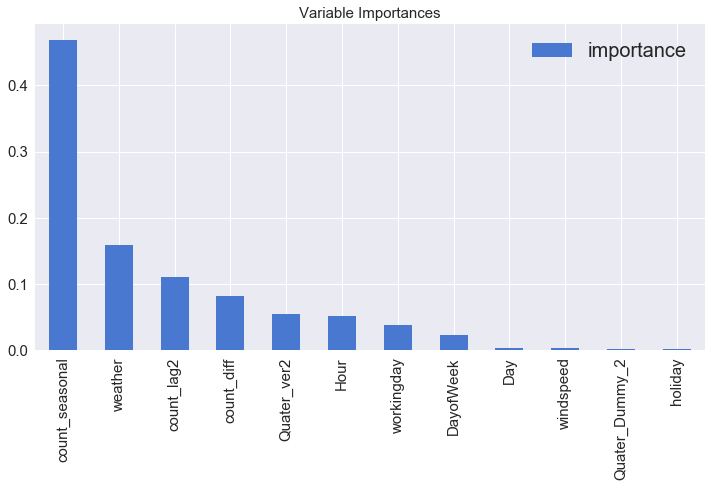

In [148]:
# Prediction Effect of Variables
Variable_Importances = pd.DataFrame([fit_reg6.feature_importances_], 
                                    columns=X_train_feRSM.columns, 
                                    index=['importance']).T.sort_values(by=['importance'], ascending=False)
display(Variable_Importances)
Variable_Importances.plot.bar(figsize=(12,6), fontsize=15)
plt.title('Variable Importances', fontsize=15)
plt.show()

,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-16.29,0.83,986.65,"1,017.83","1,064.64","1,511.62",3.04
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,27.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,100.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"98,935.83",nan,nan,nan,nan,nan,NaN


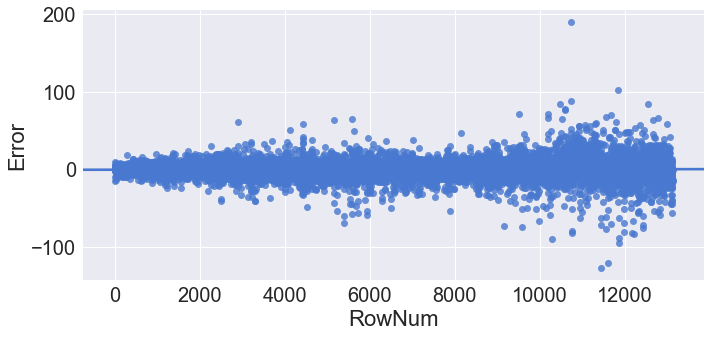

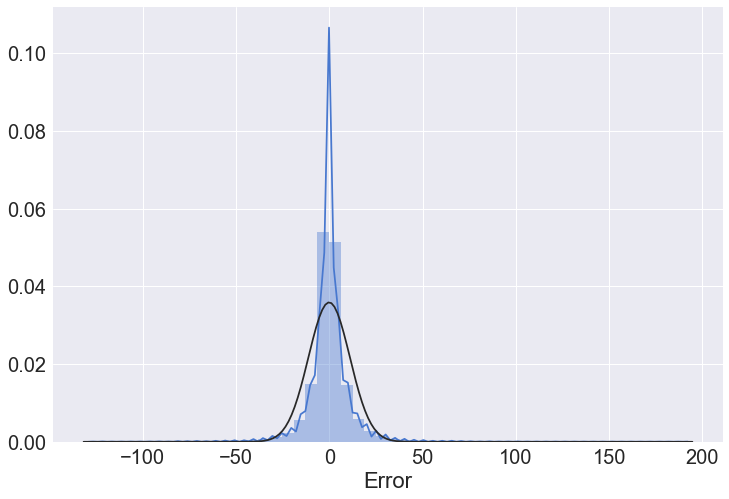

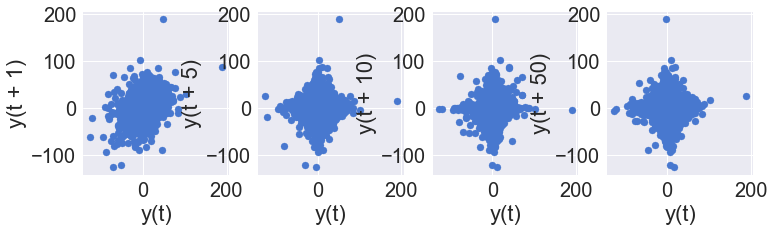

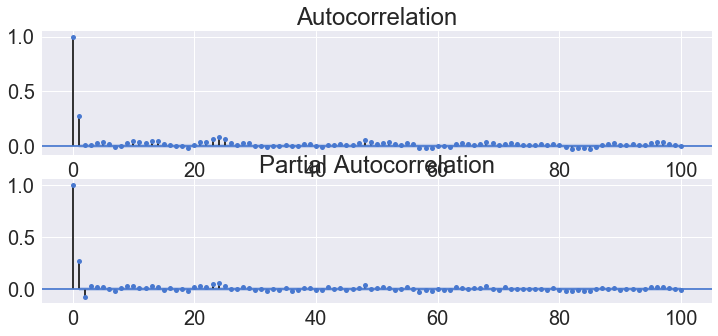

In [149]:
# Error Analysis
error_analysis(Resid_tr_reg6_feRSM, ['Error'], X_train_feRSM, graph_on=True)